In [1]:
import os

# move up from notebooks -> project root
os.chdir(os.path.join(os.getcwd(),os.pardir))
print("Working dir is now:", os.getcwd())


import torch 
import numpy as np
import matplotlib.pyplot as plt

from initialize import OUTPUT_PATH, PREPROCESSED_AURORA_DATA_PATH


Working dir is now: /Users/adrian/Documents/01_projects/02_clean_ppg


In [2]:
data_path = os.path.join(PREPROCESSED_AURORA_DATA_PATH, "data_dict_osc_auc_with_derivatives_with_classes.pt")
# Load the data
data = torch.load(data_path, weights_only=False)

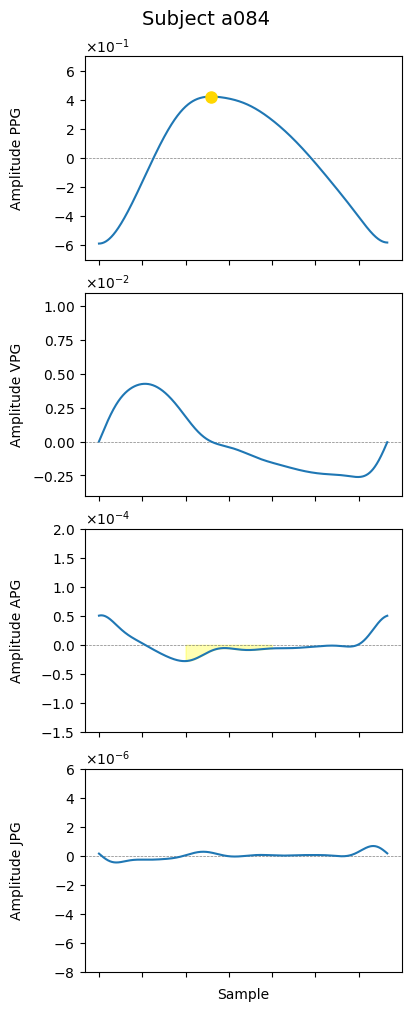

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import argrelextrema

os.makedirs(os.path.join(OUTPUT_PATH, "waves_and_derivatives_for_each_subject"), exist_ok=True)

wave_types       = ["ensemble_ppg_avg", "ensemble_vpg_avg", "ensemble_apg_avg", "ensemble_jpg_avg"]
names_wave_types = ["PPG",   "VPG",   "APG",   "JPG"]
# y axis limits for each wave type
y_limits = {
    "ensemble_ppg_avg": (-0.7e0, 0.7e0),
    "ensemble_vpg_avg": (-0.4e-2, 1.1e-2),
    "ensemble_apg_avg": (-1.5e-4, 2.0e-4),
    "ensemble_jpg_avg": (-8e-6, 6e-6)
}

for subj_id, subject_data in data.items():
    # Turn on constrained_layout so space for labels/offsets is reserved automatically
    fig, axes = plt.subplots(4, 1,
                             figsize=(4, 10),
                             sharex=True,
                             constrained_layout=True)
    

    subj_id = "a084"

    fig.suptitle(f"Subject {subj_id}", fontsize=14)

    for ax, wave_type, name in zip(axes, wave_types, names_wave_types):

        # plot a horizontal line at y=0
        ax.axhline(0, color='gray', lw=0.5, ls='--')

        # plot the wave type data
        ax.plot(subject_data[wave_type])

        # --- Scientific formatting with a shared offset ---
        ax.ticklabel_format(style='scientific',
                            axis='y',
                            scilimits=(-1, 1),
                            useMathText=True)

        # Force the offset-text to the *left* of the axis
        ax.yaxis.offsetText.set_x(-0.1)        # tweak horizontal position
        ax.yaxis.offsetText.set_ha('right')    # right-align so it hugs the ticklabels
        ax.yaxis.set_offset_position('left')   # tell Matplotlib it belongs on the left
        ax.set_ylim(y_limits[wave_type])

        # Label on the left, same pad for all
        ax.set_ylabel(f"Amplitude {name}", labelpad=6)

        # Add a yellow big point to the peak of the PPG wave. Add small blue dots for all local maxima and minima of the PPG wave.
        if wave_type == "ensemble_ppg_avg":
            
            # Add small blue dots for all local maxima and minima of the PPG wave.
            local_max_indices = argrelextrema(subject_data[wave_type], np.greater)[0]
            local_min_indices = argrelextrema(subject_data[wave_type], np.less)[0]
            ax.plot(local_max_indices, subject_data[wave_type][local_max_indices], 'bo', markersize=5, label='Local Maxima')
            ax.plot(local_min_indices, subject_data[wave_type][local_min_indices], 'ro', markersize=5, label='Local Minima')

            # Add the big yellow point
            peak_index = np.argmax(subject_data[wave_type])
            peak_value = subject_data[wave_type][peak_index]
            ax.plot(peak_index, peak_value, color='gold', marker='o', markersize=8, label='Peak PPG')

        # Color for the APG wave the area between the wave and the x-axis yellow (but only between x=300 and x=600).
        if wave_type == "ensemble_apg_avg":
            x_fill_start = 300
            x_fill_end = 600
            # Mask the data that only if the value of the wave is at that point >0
            # to avoid filling the area below the x-axis
            y_fill = subject_data[wave_type][x_fill_start:x_fill_end]
            ax.fill_between(range(x_fill_start, x_fill_end), y_fill, color='yellow', alpha=0.3, label='APG Area')

        # Only bottom subplot gets x-tick labels
        if ax is not axes[-1]:
            ax.set_xticklabels([])
        else:
            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    axes[-1].set_xlabel("Sample")

    # This will align all y-labels in one vertical column
    fig.align_ylabels(axes)

    plt.savefig(os.path.join(OUTPUT_PATH, "waves_and_derivatives_for_each_subject", f"subject_{subj_id}_pulse_wave_and_derivatives.png"))
    plt.show()
    break



In [4]:
# # compare the ensemble PPG signals for finger and wrist
# os.makedirs(OUTPUT_PATH+"/finger_vs_wrist", exist_ok=True)

# id = "002" #02, 11, 12, 21,-> Attention: 13, 14, 18, 19 does not work - fingerPPG is zero (I guess my algo excluded this due to too low quality?)! 
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.plot(finger_data[id]["ensemble_ppg"], label='Finger PPG')
# plt.xlabel("Sample Index")
# plt.ylabel("Normalized Amplitude")
# plt.title("Finger")

# plt.subplot(1, 2, 2)
# plt.plot(wrist_data[id]["ensemble_ppg"], label='Wrist PPG')
# plt.title("Wrist")
# plt.xlabel("Sample Index")
# plt.yticks([])  # Hide y-ticks for clarity

# plt.suptitle("Ensemble PPG Signals for Finger and Wrist")
# plt.tight_layout()
# plt.savefig(OUTPUT_PATH +"/finger_vs_wrist/ensemble_ppg_signals.png")
# plt.savefig(OUTPUT_PATH +"/finger_vs_wrist/ensemble_ppg_signals.pdf")
# plt.show()

The total number of waves for all subjects is:  17873


Text(0.5, 1.0, 'AGAIN PYPPG PREPROCESSED DATA: Distribution of Waves per Subject. \nTotal number of waves: 17873')

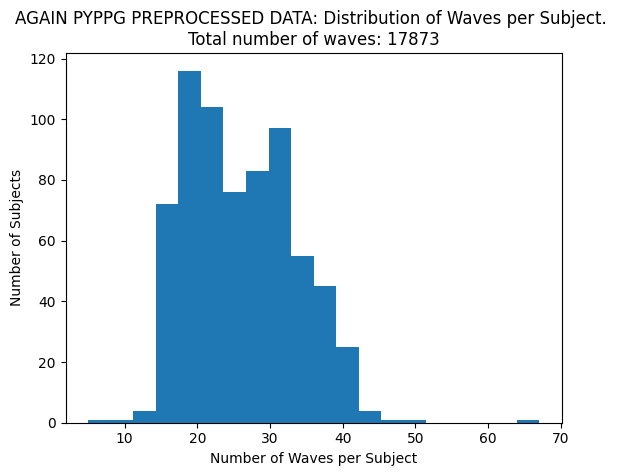

In [16]:
number_total_waves = 0 
waves_per_subject = []

for i in data: 
    # Count the number of individual waves for each subject
    waves_of_i = len(data[i]["individual_wave_derivs_ppg_arr"])
    waves_per_subject.append(waves_of_i)    
    number_total_waves += waves_of_i

print("The total number of waves for all subjects is: ", number_total_waves)

plt.hist(waves_per_subject, bins=20)
plt.xlabel("Number of Waves per Subject") 
plt.ylabel("Number of Subjects")
plt.title("AGAIN PYPPG PREPROCESSED DATA: Distribution of Waves per Subject. \nTotal number of waves: " + str(number_total_waves))


In [19]:
data["a000"].keys()  # to see the available subjects

dict_keys(['age', 'gender', 'high_bp', 'baseline_sbp', 'baseline_dbp', 'height', 'weight', 'cvd_meds', 'fitzpatrick_scale', 'pressure_quality', 'optical_quality', 'raw_optical', 'delta_t', 'sampling_rate', 'ppg', 'vpg', 'apg', 'jpg', 'fiducials_pyPPG', 'individual_waves', 'fid_on_ppg', 'wave_durations', 'average_hr', 'rise_times_norm', 'rise_times_ms', 'average_rise_time_norm', 'average_rise_time_ms', 'ensemble_wave', 'ensemble_ppg', 'ensemble_vpg', 'ensemble_apg', 'ensemble_jpg', 'individual_wave_derivs_ppg_arr', 'individual_wave_derivs_vpg_arr', 'individual_wave_derivs_apg_arr', 'individual_wave_derivs_jpg_arr', 'ensemble_ppg_avg', 'ensemble_vpg_avg', 'ensemble_apg_avg', 'ensemble_jpg_avg', 'oscillo_or_auscul', 'bmi', 'height_m', 'weight_kg', 'individual_waves_classes', 'ensemble_class', 'area_under_the_curve_unsign_wave', 'area_under_the_curve_sign_wave', 'area_under_the_curve_unsign', 'area_under_the_curve_sign'])

The total number of waves for all subjects is:  17873


Text(0.5, 1.0, 'BEFORE PYPPG PREPROCESSED DATA: Distribution of Waves per Subject. \nTotal number of waves: 17873')

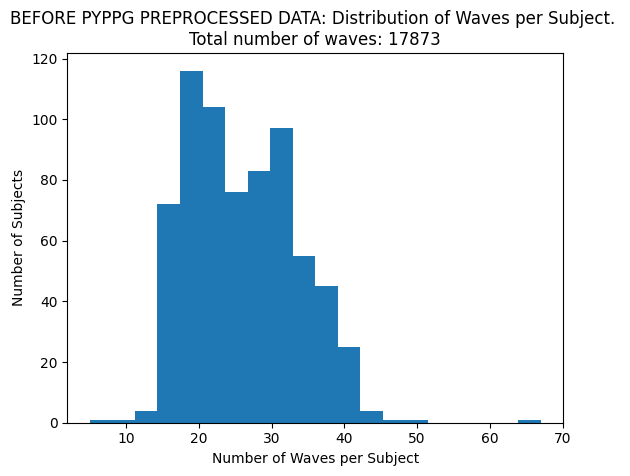

In [21]:
number_total_waves = 0 
waves_per_subject = []

for i in data: 
    # Count the number of individual waves for each subject
    waves_of_i = len(data[i]["individual_waves"])
    waves_per_subject.append(waves_of_i)    
    number_total_waves += waves_of_i

print("The total number of waves for all subjects is: ", number_total_waves)

plt.hist(waves_per_subject, bins=20)
plt.xlabel("Number of Waves per Subject") 
plt.ylabel("Number of Subjects")
plt.title("BEFORE PYPPG PREPROCESSED DATA: Distribution of Waves per Subject. \nTotal number of waves: " + str(number_total_waves))


In [35]:
data["a000"].keys()  # to see the available subjects

dict_keys(['age', 'gender', 'high_bp', 'baseline_sbp', 'baseline_dbp', 'height', 'weight', 'cvd_meds', 'fitzpatrick_scale', 'pressure_quality', 'optical_quality', 'raw_optical', 'delta_t', 'sampling_rate', 'ppg', 'vpg', 'apg', 'jpg', 'fiducials_pyPPG', 'individual_waves', 'fid_on_ppg', 'wave_durations', 'average_hr', 'rise_times_norm', 'rise_times_ms', 'average_rise_time_norm', 'average_rise_time_ms', 'ensemble_wave', 'ensemble_ppg', 'ensemble_vpg', 'ensemble_apg', 'ensemble_jpg', 'individual_wave_derivs_ppg_arr', 'individual_wave_derivs_vpg_arr', 'individual_wave_derivs_apg_arr', 'individual_wave_derivs_jpg_arr', 'ensemble_ppg_avg', 'ensemble_vpg_avg', 'ensemble_apg_avg', 'ensemble_jpg_avg', 'oscillo_or_auscul', 'bmi', 'height_m', 'weight_kg', 'individual_waves_classes', 'ensemble_class', 'area_under_the_curve_unsign_wave', 'area_under_the_curve_sign_wave', 'area_under_the_curve_unsign', 'area_under_the_curve_sign'])

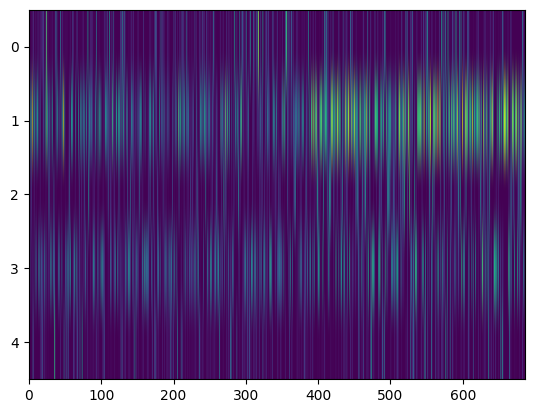

In [ ]:
# count how many waves are of class 1,2,3,4,5 for each subject
wave_counts = []
for i in data:
    wave_arr = np.zeros(5)
    class_index, w_classes = np.unique(data[i]["individual_waves_classes"], return_counts=True)
    for class_id, w_class in zip(class_index, w_classes):
        wave_arr[class_id-1] = w_class 

    wave_counts.append(wave_arr)

wave_counts = np.array(wave_counts)

plt.imshow(np.array(wave_counts).T, aspect='auto', cmap='viridis')

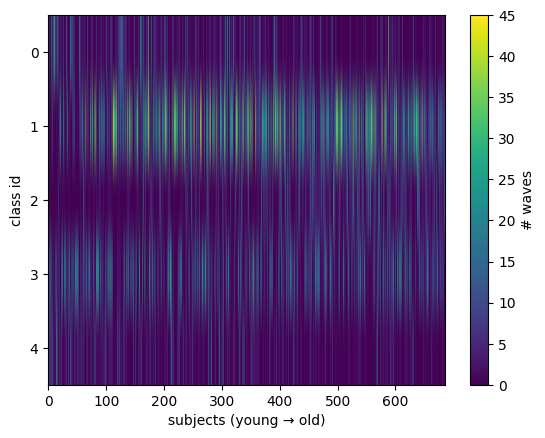

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. collect ages in the SAME order that you built `wave_counts`
# ------------------------------------------------------------------
subjects   = list(data.keys())              # or whatever iterable you used
ages       = np.array([data[s]['age'] for s in subjects])

# argsort returns the indices that would sort the ages
age_order  = np.argsort(ages)               # youngest → oldest
# ------------------------------------------------------------------
# 2. reorder the rows of wave_counts, then plot
# ------------------------------------------------------------------
wave_age   = wave_counts[age_order]         # (n_subj, 5)
plt.imshow(wave_age.T, aspect='auto', cmap='viridis')
plt.xlabel('subjects (young → old)'); plt.ylabel('class id')
plt.colorbar(label='# waves')
plt.show()


In [ ]:
wave_counts.shape # 686, 5

np.mean(wave_counts, axis=1).shape # (686,)

wave_counts/np.mean(wave_counts, axis=1)

(686,)

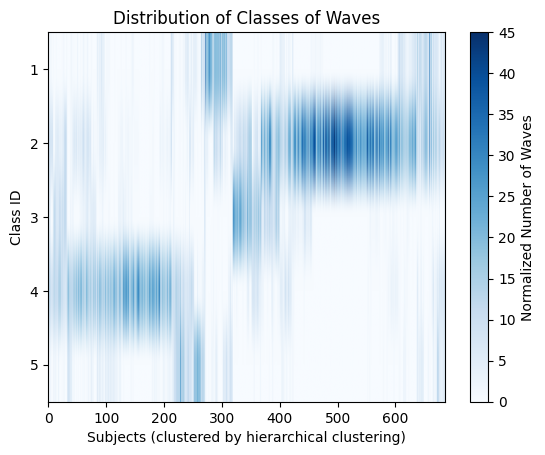

In [76]:
import numpy as np
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, leaves_list

os.makedirs(os.path.join(OUTPUT_PATH, "class_analysises"), exist_ok=True)
# ------------------------------------------------------------------
# 1. L1-normalise each subject's counts  (sum of row = 1)
# ------------------------------------------------------------------
wave_norm  = wave_counts/np.mean(wave_counts, axis=1, keepdims=True) # normalize(wave_counts, norm='l1')   # shape (n_subj, 5)

# ------------------------------------------------------------------
# 2. Hierarchical clustering   (cosine distance works well here)
# ------------------------------------------------------------------
Z          = linkage(wave_norm, method='average', metric='cosine')
cluster_order = leaves_list(Z)                   # optimal leaf order

# ------------------------------------------------------------------
# 3. Re-plot with the new column order
# ------------------------------------------------------------------
wave_clust = wave_counts[cluster_order]
plt.imshow(wave_clust.T, aspect='auto', cmap='Blues')
plt.xlabel('Subjects (clustered by hierarchical clustering)'); plt.ylabel('Class ID')
plt.colorbar(label="Normalized Number of Waves")
plt.title("Distribution of Classes of Waves")
plt.yticks(range(5), range(1, 6))  # Set x-ticks to class IDs 1-5
plt.savefig(os.path.join(OUTPUT_PATH, "class_analysises", "classes_of_waves.png"))
plt.savefig(os.path.join(OUTPUT_PATH, "class_analysises", "classes_of_waves.pdf"))
plt.show()



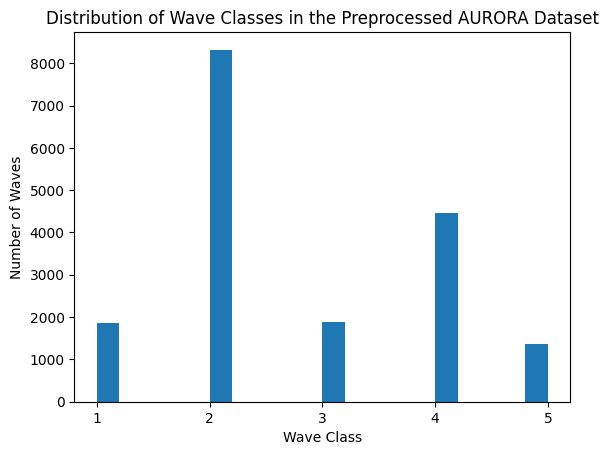

The number of waves per class is:  (array([1, 2, 3, 4, 5], dtype=int8), array([1857, 8319, 1888, 4451, 1358]))
The rounded percentage of waves per class is: 
Class 1: 10.39%
Class 2: 46.55%
Class 3: 10.56%
Class 4: 24.9%
Class 5: 7.6%


In [74]:
wave_classes = []
for i in data: 
    # Count the number of individual waves for each subject
    wave_classes_of_i = data[i]["individual_waves_classes"]
    for w in wave_classes_of_i:
        wave_classes.append(w)
    # wave_classes.append(wave_classes_of_i)  
plt.hist(np.array(wave_classes).flatten(), bins=20)
plt.xticks(np.arange(1, 6, 1))

plt.xlabel("Wave Class")
plt.ylabel("Number of Waves")
plt.title("Distribution of Wave Classes in the Preprocessed AURORA Dataset")
plt.show()

print("The number of waves per class is: ", np.unique(np.array(wave_classes), return_counts=True))
percentages_per_class = np.unique(np.array(wave_classes), return_counts=True)[1]/len(wave_classes) * 100
print("The rounded percentage of waves per class is: ") 
for i, p in enumerate(percentages_per_class):
    print(f"Class {i+1}: {np.round(p,2)}%")
